In [16]:
import numpy as np
import pandas as pd

from scipy.interpolate import LinearNDInterpolator
from time import time
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv('/home/ADF/ajl573/Data/interstellar_data/tracks_04c/tracks_04c_train.csv')
train.head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,frac_age,effective_T,luminosity,radius,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,initial_Zinit,frac_evol,gradient,log_star_age
0,2,0.90,0.28,0.30,2.1,1.208001,5096.0684,1.257615,1.440663,4.074041,0.250045,0.023094,0.244397,75.369644,0.025096,1.787780,0.001331,1.288534
1,1,1.05,0.30,0.35,2.3,0.802252,5795.2236,1.241361,1.106796,4.370944,0.265167,0.024596,0.281803,119.692590,0.027260,0.802252,0.000143,0.769161
2,1,1.00,0.26,0.45,1.5,0.257848,4885.7940,0.461555,0.949512,4.482889,0.244987,0.034190,0.418402,147.281680,0.035917,0.257848,0.000186,0.602735
3,1,0.83,0.24,0.10,1.7,0.133108,4709.6700,0.263781,0.772503,4.581167,0.230248,0.016330,0.078280,182.489150,0.016932,0.133108,0.000198,0.506814
4,1,1.20,0.32,-0.40,1.7,0.570906,7567.7803,5.058152,1.310140,4.282435,0.211951,0.003404,-0.620390,90.396866,0.004865,0.570906,0.000695,0.055732


In [3]:
test = pd.read_csv('/home/ADF/ajl573/Data/interstellar_data/tracks_04c_test/tracks_04c_test_data.csv')
test.head()

,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,star_age,frac_age,effective_T,luminosity,radius,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,frac_evol,gradient
0,1,0.955,0.29,0.017696,0.15,1.4,0.101533,0.010515,5340.6064,0.601833,0.907436,4.502261,0.289404,0.017670,0.148902,153.64706,0.010515,0.000304
1,1,0.955,0.29,0.017696,0.15,1.4,0.113827,0.011788,5342.0340,0.603564,0.908254,4.501479,0.289308,0.017665,0.148715,153.44257,0.011788,0.000293
2,1,0.955,0.29,0.017696,0.15,1.4,0.128580,0.013316,5343.3000,0.605240,0.909083,4.500686,0.289194,0.017659,0.148491,153.23601,0.013316,0.000272
3,1,0.955,0.29,0.017696,0.15,1.4,0.146284,0.015149,5344.3800,0.606864,0.909934,4.499873,0.289055,0.017652,0.148219,153.02490,0.015149,0.000255
4,1,0.955,0.29,0.017696,0.15,1.4,0.167529,0.017350,5345.3080,0.608473,0.910823,4.499025,0.288889,0.017643,0.147893,152.80542,0.017350,0.000250


In [4]:
x_cols = [
    'frac_evol', 'initial_mass', 'initial_MLT', 'initial_Yinit', 'initial_Zinit'
]

In [105]:
y_cols = [
    'log_star_age', 'effective_T', 'radius', 'delta_nu_fit', 'star_feh'
]

In [121]:
n_start = 10
n_stop = 1000
n_points = 20
n_samples = np.linspace(n_start, n_stop, n_points, dtype=int)
elapsed_time = []

for n in n_samples:
    sample = train.sample(n)
    points = sample[x_cols].to_numpy()
    values = sample[y_cols].to_numpy()
    
    start_time = time()
    interpolator = LinearNDInterpolator(points, values)
    current_time = time()
    elapsed_time.append(current_time - start_time)

In [122]:
fit = np.polyfit(n_samples, elapsed_time, 2)

x = np.linspace(n_start, n_stop, 100)
estimated_time = np.poly1d(fit)
y = estimated_time(x)

Text(0, 0.5, 'time (s)')

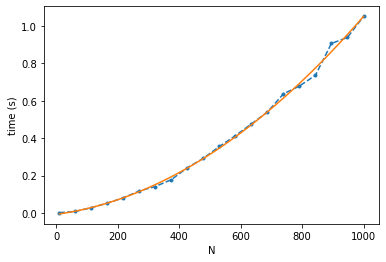

In [123]:
plt.plot(n_samples, elapsed_time, '.--')
plt.plot(x, y)
plt.xlabel('N')
plt.ylabel('time (s)')

In [64]:
def condition(df):
    cond = df['log_star_age'].between(np.log10(4.5), np.log10(5.5)) & \
        df['effective_T'].between(5000, 6000) & \
        df['radius'].between(1, 1.5) & \
        df['delta_nu_fit'].between(100, 130) & \
        df['star_feh'].between(-0.1, 0.1)
    return cond

In [65]:
cond = condition(train)

In [66]:
points = train.loc[cond, x_cols].to_numpy()
values = train.loc[cond, y_cols].to_numpy()

In [67]:
t = estimated_time(len(points))
print(f'estimated time = {t:.0f} s or {t/60:.0f} min')

estimated time = 184 s or 3 min


In [69]:
interpolator = LinearNDInterpolator(points, values, rescale=True)

In [73]:
test['log_star_age'] = np.log10(test['star_age'])

In [74]:
cond = condition(test)

In [75]:
points = test.loc[cond, x_cols].to_numpy()
values = test.loc[cond, y_cols].to_numpy()

predictions = interpolator(points)

In [106]:
y_pred_cols = [f'{col}_pred' for col in y_cols]

In [107]:
for col in y_pred_cols:
    test[col] = np.nan

In [108]:
test.loc[cond, y_pred_cols] = predictions

In [109]:
y_err_cols = [f'{col}_err' for col in y_cols]

In [110]:
test[y_err_cols] = pd.DataFrame(test[y_cols].to_numpy() - test[y_pred_cols].to_numpy())
test.head()

,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,star_age,frac_age,effective_T,luminosity,...,effective_T_pred,radius_pred,delta_nu_fit_pred,star_feh_pred,log_star_age_err,effective_T_err,radius_err,delta_nu_fit_err,star_feh_err,star_age_pred
0,1,0.955,0.29,0.017696,0.15,1.4,0.101533,0.010515,5340.6064,0.601833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.955,0.29,0.017696,0.15,1.4,0.113827,0.011788,5342.0340,0.603564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.955,0.29,0.017696,0.15,1.4,0.128580,0.013316,5343.3000,0.605240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.955,0.29,0.017696,0.15,1.4,0.146284,0.015149,5344.3800,0.606864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.955,0.29,0.017696,0.15,1.4,0.167529,0.017350,5345.3080,0.608473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
test['star_age_pred'] = 10**test['log_star_age_pred']
test['star_age_err'] = test['star_age'] - test['star_age_pred']

In [112]:
test[y_err_cols+['star_age_err']].std()

log_star_age_err    0.003631
effective_T_err     7.014917
radius_err          0.004063
delta_nu_fit_err    0.393850
star_feh_err        0.001528
star_age_err        0.040674
dtype: float64

In [119]:
len(points)

7835

In [113]:
n_total = len(train)
print('n_total = ', n_total)

n_total =  7736000


In [116]:
t = estimated_time(n_total)
print(f'total estimated time = {t:.0f} s or {t/60:.0f} min or {t/60/60:.0f} hrs or {t/60/60/24:.0f} days')

total estimated time = 52290427 s or 871507 min or 14525 hrs or 605 days
